[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os

os.environ["ROBOFLOW_API_KEY"] = ""

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sun Apr  6 12:57:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-06 12:59:37--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-06 12:59:38 (112 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 223MB/s]


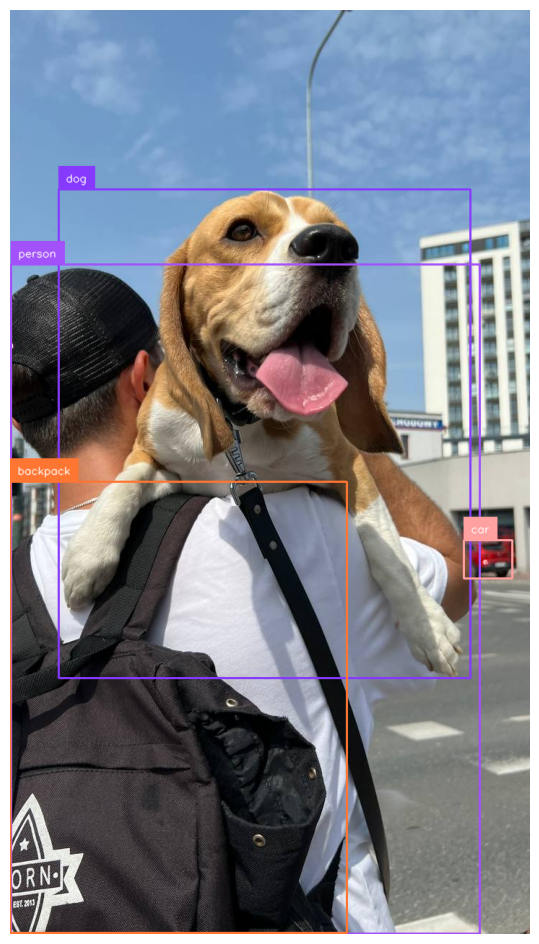

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [8]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("").project("")
version = project.version(6)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to FER2025_ML_Project-6 in yolov12:: 100%|██████████| 3898/3898 [00:00<00:00, 7028.10it/s]


In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 12
names: ['angry_female', 'angry_male', 'fear_female', 'fear_male', 'happy_female', 'happy_male', 'sad_female', 'sad_male', 'sleepy_female', 'sleepy_male', 'surprised_female', 'surprised_male']

roboflow:
  workspace: university-f1igv
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=30)

New https://pypi.org/project/ultralytics/8.3.102 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/FER2025_ML_Project-6/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fa

100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 65.7MB/s]


AMP: checks passed ✅


train: Scanning /content/FER2025_ML_Project-6/train/labels... 1361 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1361/1361 [00:00<00:00, 2567.76it/s]

train: New cache created: /content/FER2025_ML_Project-6/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/FER2025_ML_Project-6/valid/labels... 389 images, 0 backgrounds, 0 corrupt: 100%|██████████| 389/389 [00:00<00:00, 1575.85it/s]

val: New cache created: /content/FER2025_ML_Project-6/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       6.8G      3.344      4.985      4.164          2        640: 100%|██████████| 86/86 [00:48<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]

                   all        389        612   0.000532      0.159   0.000777   0.000181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.93G       2.91      4.739      3.729          5        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

                   all        389        612    0.00409      0.462    0.00635    0.00183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.92G      2.469      4.232      3.137          3        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


                   all        389        612     0.0583      0.158     0.0366     0.0138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.78G      2.205      3.832      2.702          5        640: 100%|██████████| 86/86 [00:45<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


                   all        389        612     0.0642      0.268     0.0671     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.75G      2.072      3.592      2.506          3        640: 100%|██████████| 86/86 [00:44<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


                   all        389        612     0.0685      0.248     0.0781      0.036

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.94G      1.978      3.383      2.382          3        640: 100%|██████████| 86/86 [00:45<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


                   all        389        612     0.0884      0.276     0.0877     0.0413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.76G      1.883      3.225      2.273          1        640: 100%|██████████| 86/86 [00:45<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

                   all        389        612      0.186      0.277      0.102     0.0471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.95G      1.826      3.062      2.205          1        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


                   all        389        612      0.103       0.38      0.117     0.0543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.92G      1.784      2.995      2.153          4        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]

                   all        389        612      0.102      0.304      0.119     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.78G      1.749      2.904      2.117          6        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]

                   all        389        612      0.122      0.353       0.12     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.91G      1.706      2.835      2.078          3        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

                   all        389        612      0.142      0.388       0.14     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.95G       1.68      2.749      2.039          4        640: 100%|██████████| 86/86 [00:45<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]

                   all        389        612      0.138      0.411      0.154     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.92G      1.626      2.684      1.994          4        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

                   all        389        612      0.156      0.403      0.177      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.77G      1.596      2.641      1.968          6        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

                   all        389        612      0.162      0.429      0.164     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.74G      1.587        2.6      1.939          2        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]

                   all        389        612      0.155      0.434      0.174     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.93G      1.556       2.57      1.926          2        640: 100%|██████████| 86/86 [00:45<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]

                   all        389        612      0.148      0.416      0.179      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       6.9G      1.527      2.543      1.908          4        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


                   all        389        612      0.183      0.425      0.196      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.77G      1.511      2.502      1.883          1        640: 100%|██████████| 86/86 [00:45<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]

                   all        389        612      0.147      0.461      0.177      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.74G      1.486      2.477      1.861          4        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]

                   all        389        612      0.175      0.452      0.201      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.96G      1.461      2.446      1.838          3        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

                   all        389        612      0.187      0.407      0.207      0.122


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       6.9G      1.407      2.268      1.853          1        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]

                   all        389        612      0.183      0.507      0.206      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.76G      1.369      2.198      1.821          2        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

                   all        389        612      0.212      0.457      0.244      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.74G      1.326      2.148      1.768          2        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

                   all        389        612      0.206       0.46      0.234      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.93G      1.322      2.106      1.764          1        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

                   all        389        612      0.218      0.473       0.25      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.94G      1.303      2.068      1.749          2        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all        389        612      0.224      0.445      0.259      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.76G      1.279      2.047       1.73          2        640: 100%|██████████| 86/86 [00:45<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

                   all        389        612      0.215      0.517      0.265      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.73G      1.253      2.005      1.707          1        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

                   all        389        612      0.227      0.514      0.273      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.93G      1.247      2.004      1.707          2        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all        389        612      0.242      0.477      0.275       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.92G      1.223      1.969      1.684          1        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.70it/s]

                   all        389        612      0.238       0.47      0.286       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.76G      1.218      1.976      1.694          1        640: 100%|██████████| 86/86 [00:45<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all        389        612      0.241      0.455      0.288      0.191



30 epochs completed in 0.435 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,078,852 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


                   all        389        612      0.243      0.457      0.288      0.191
          angry_female         40         47      0.192      0.399      0.241      0.169
            angry_male         37         40      0.232      0.575      0.319      0.219
           fear_female         47         62      0.209      0.563      0.259      0.154
             fear_male         43         56      0.194      0.515      0.252      0.163
          happy_female         45         60      0.213       0.35      0.266      0.139
            happy_male         44         62      0.401      0.496      0.458      0.303
            sad_female         25         33      0.205      0.545      0.231      0.168
              sad_male         41         44      0.256      0.312      0.276      0.191
         sleepy_female         41         59      0.243      0.102      0.184      0.111
           sleepy_male         27         35       0.27      0.343      0.274      0.181
      surprised_femal

## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   R_curve.png		val_batch0_labels.jpg
confusion_matrix_normalized.png			   results.csv		val_batch0_pred.jpg
confusion_matrix.png				   results.png		val_batch1_labels.jpg
events.out.tfevents.1743944702.bdd5227810d8.178.0  train_batch0.jpg	val_batch1_pred.jpg
F1_curve.png					   train_batch1720.jpg	val_batch2_labels.jpg
labels_correlogram.jpg				   train_batch1721.jpg	val_batch2_pred.jpg
labels.jpg					   train_batch1722.jpg	weights
P_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch2.jpg


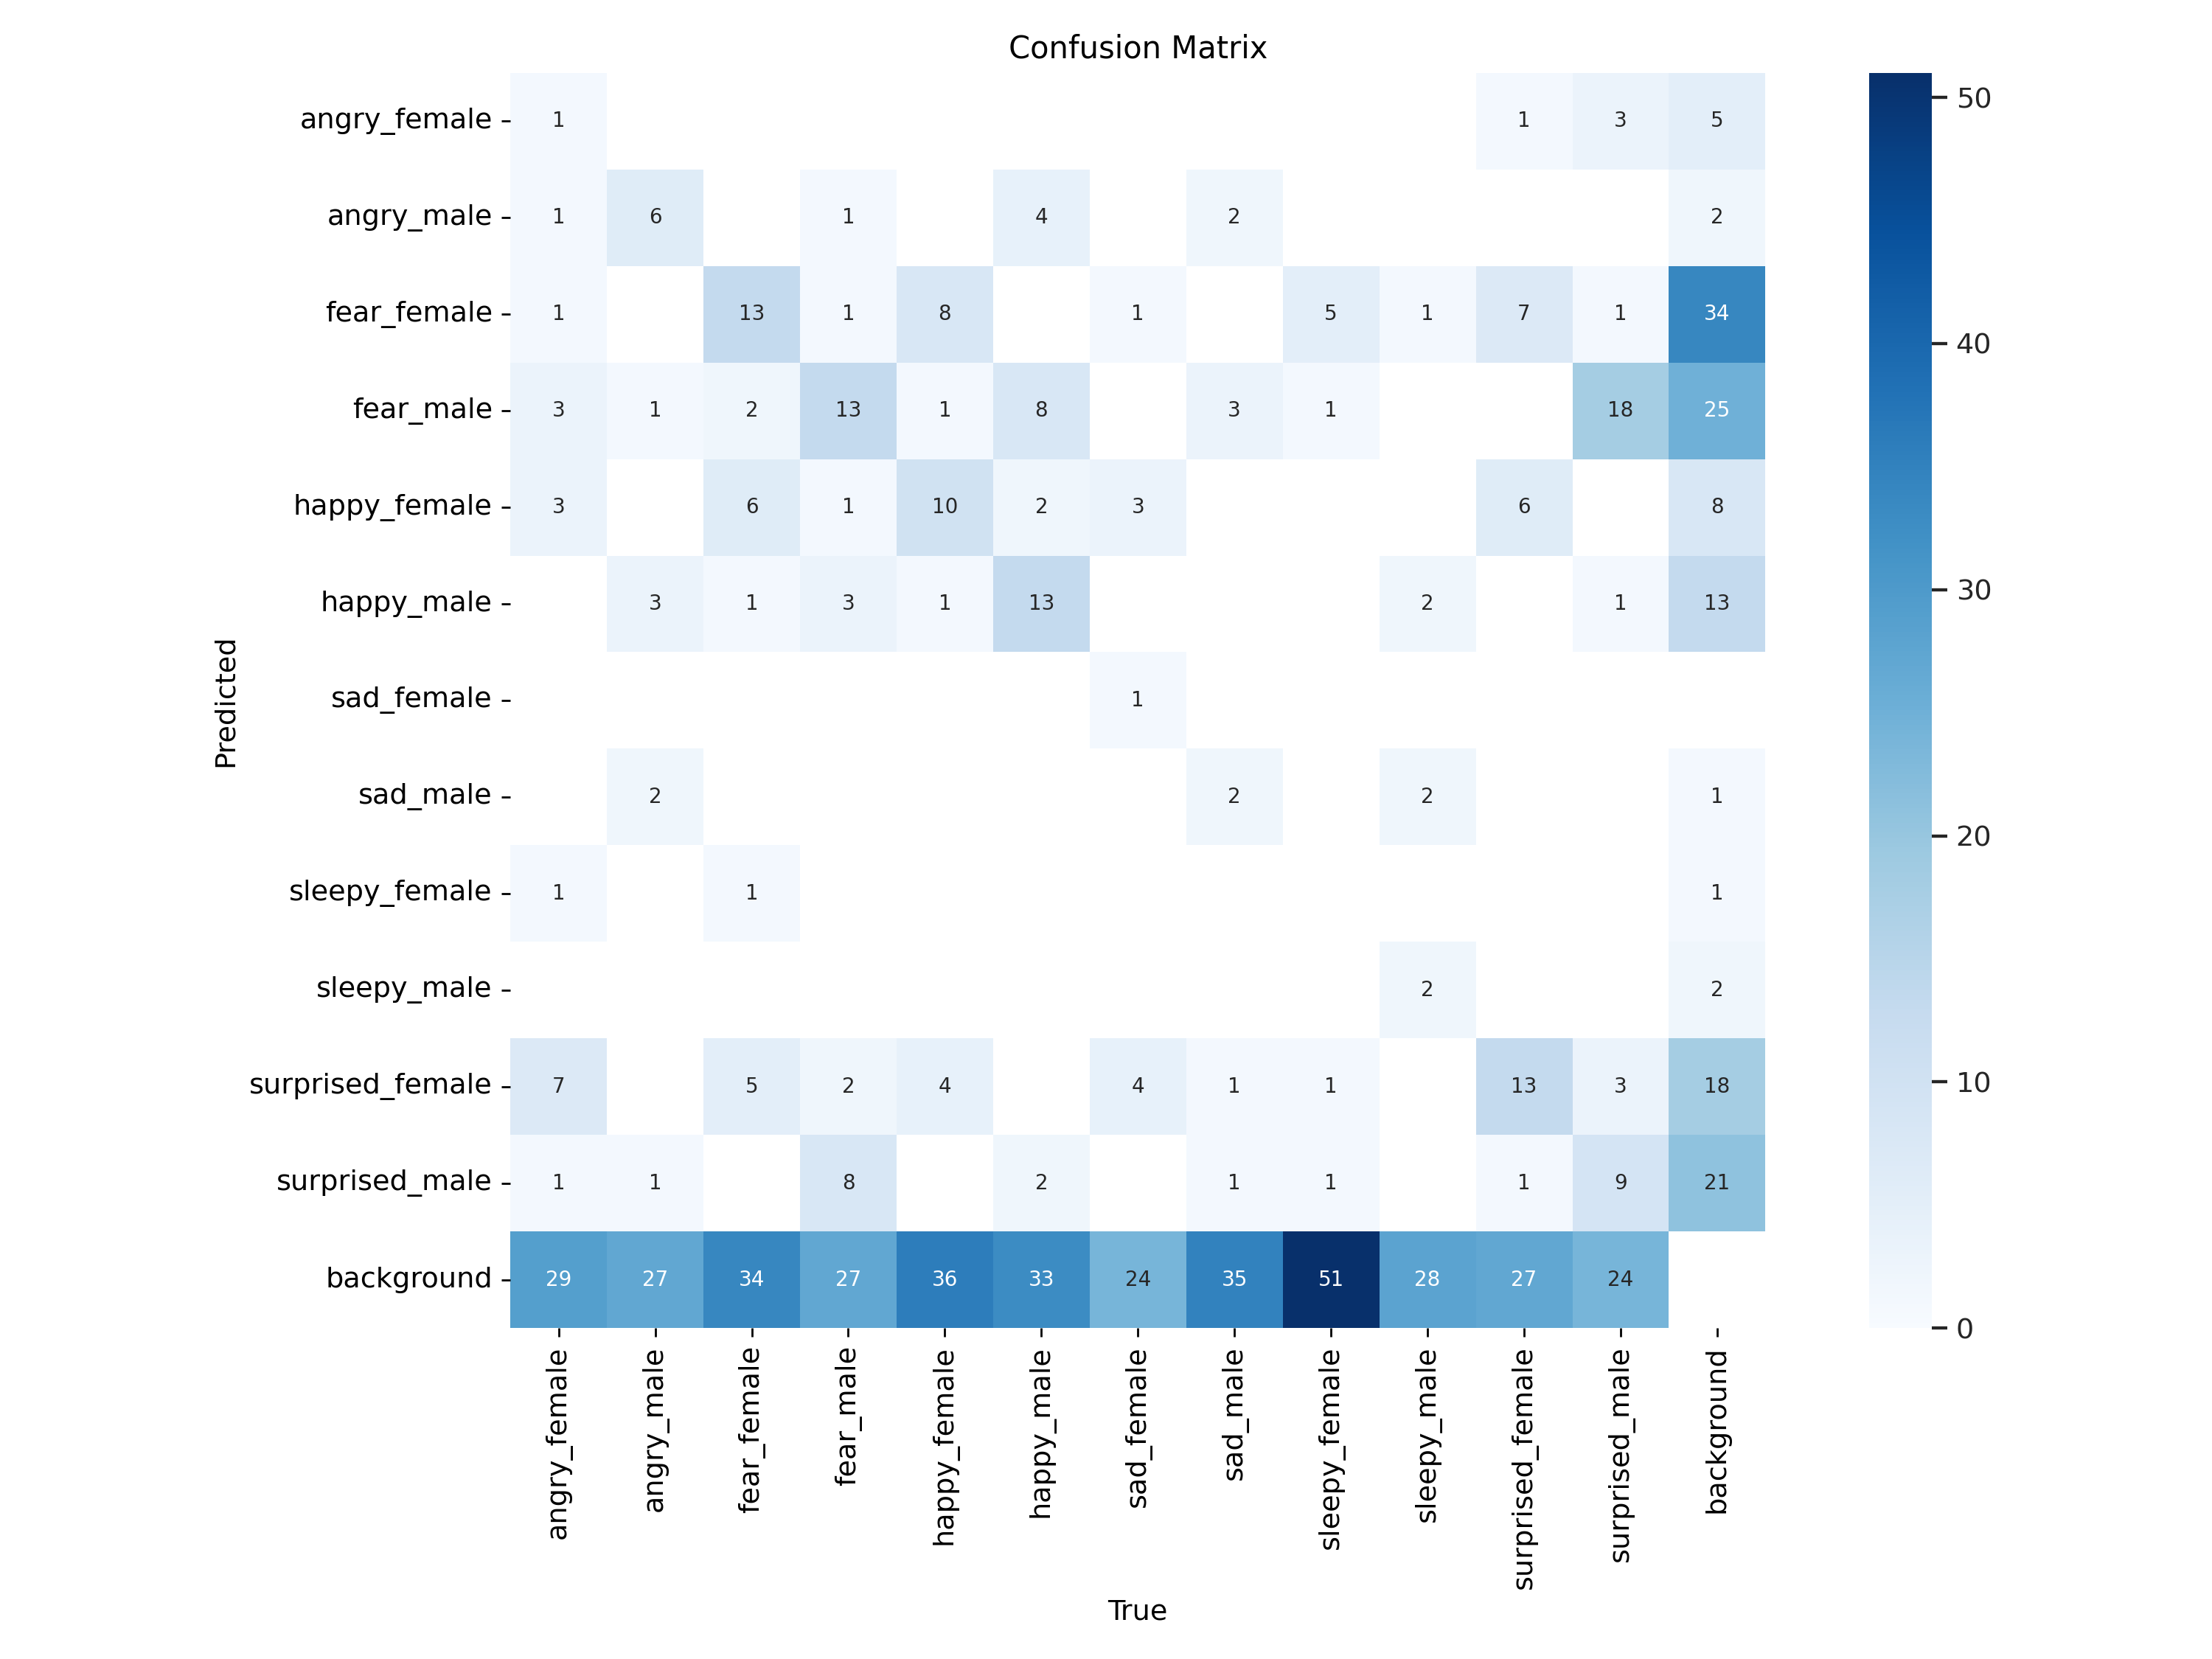

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

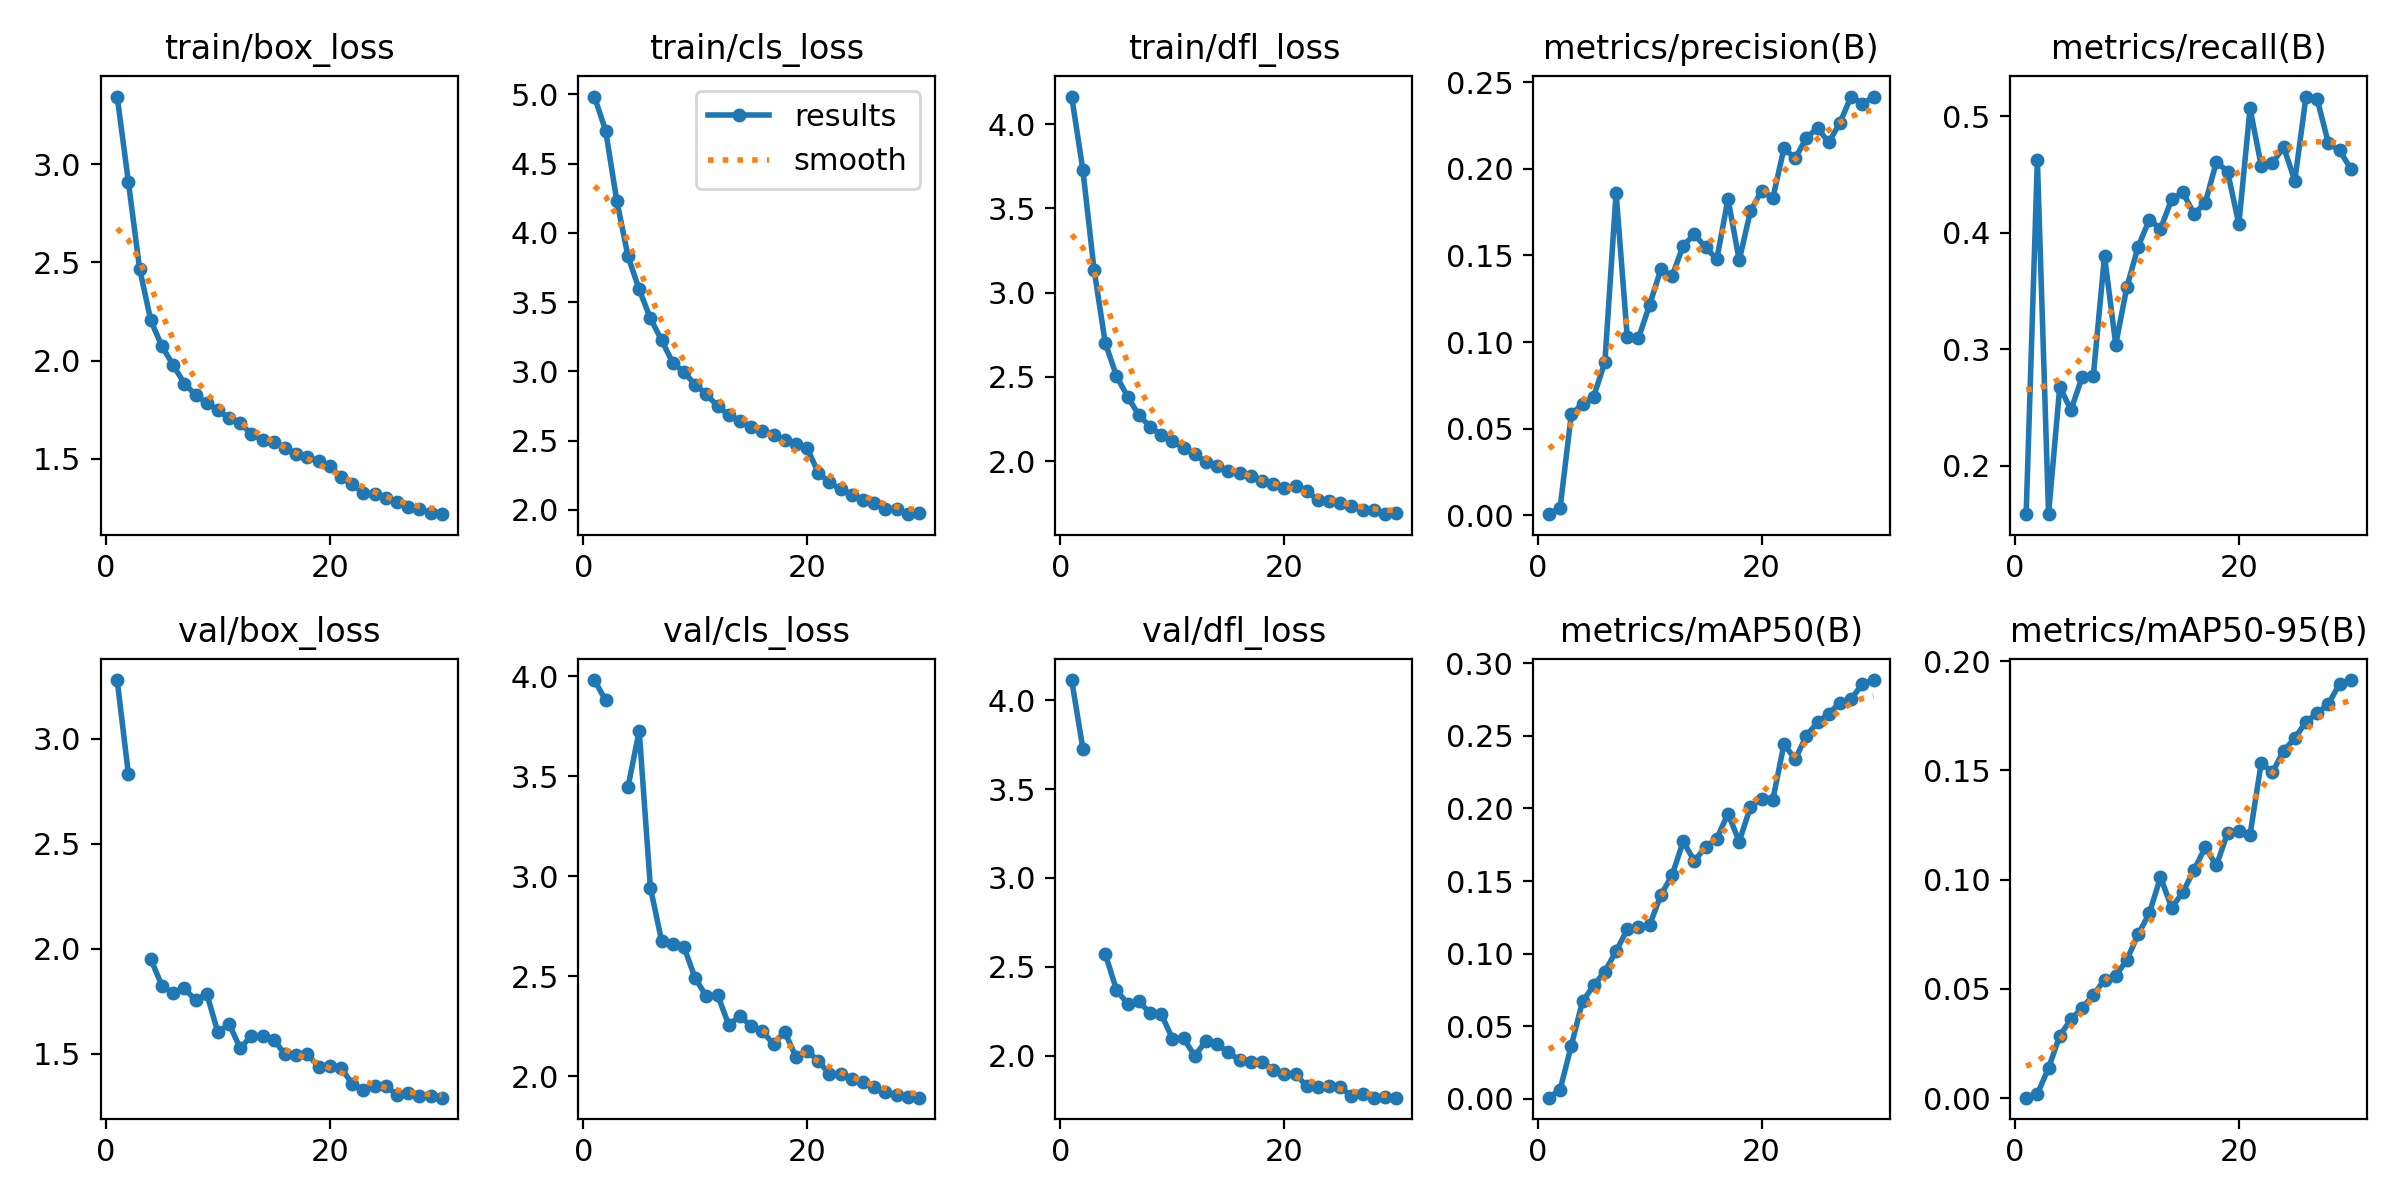

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['angry_female',
 'angry_male',
 'fear_female',
 'fear_male',
 'happy_female',
 'happy_male',
 'sad_female',
 'sad_male',
 'sleepy_female',
 'sleepy_male',
 'surprised_female',
 'surprised_male']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.05738221518839255
mAP 50 0.08663566343694412
mAP 75 0.06976229714068716


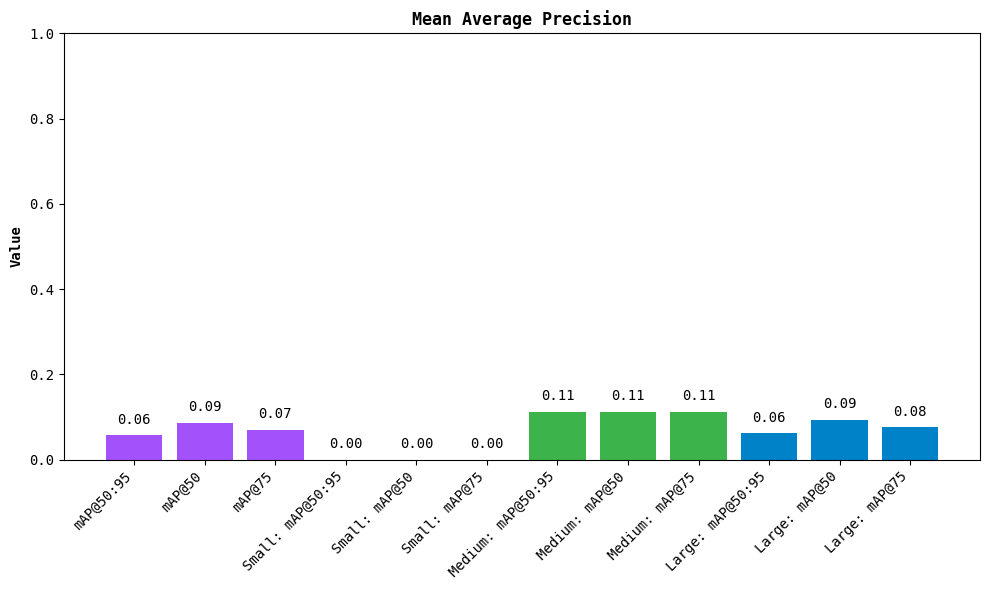

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

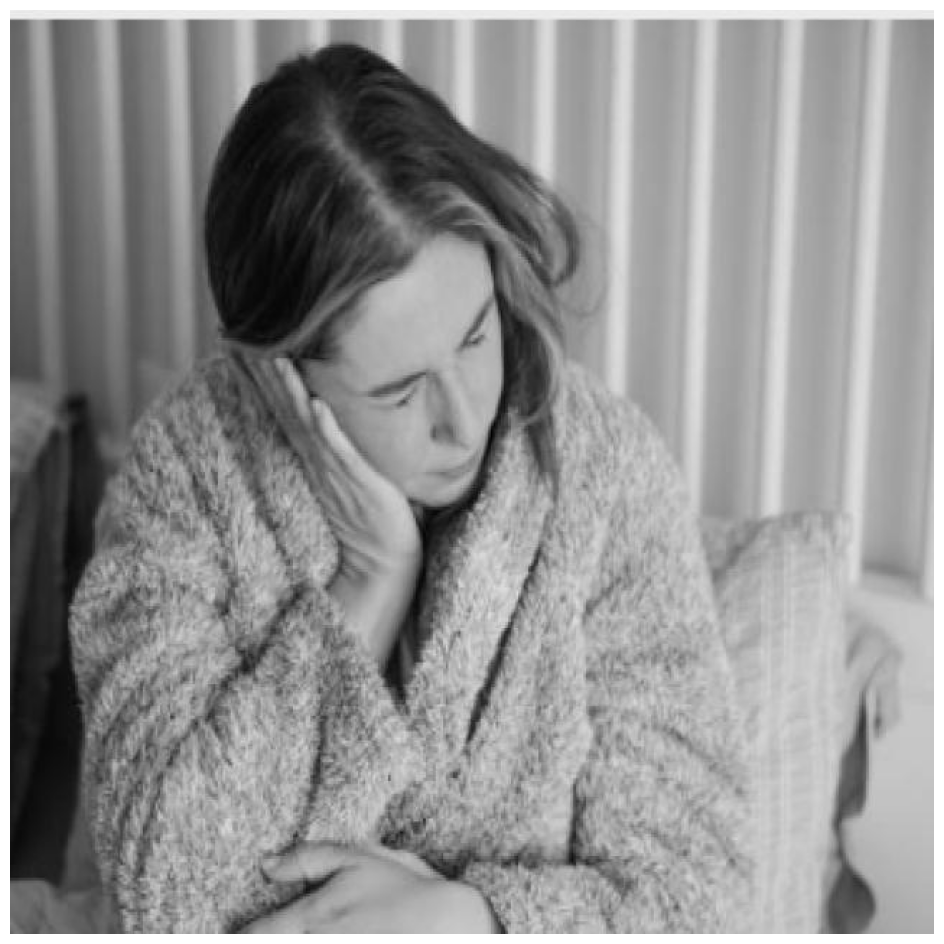

In [21]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)